[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiptos/is_notes/blob/main/cnn_transfer.ipynb)

# Introduction

In this example, we will use the CIFAR10 dataset, based on this [Pytorch Example](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). It has the classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

# Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models

## Set the device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


## Load and normalize CIFAR10

We obtain the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) via torchvision. The dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. Note that `datasets` is an object imported from torchvision, not to confuse with from the Dataset object (used in torch.utils.data import Dataset)

```from torchvision import datasets```

When called for the first time, the datasets will be downloaded to the path specified in the `root` argument. After that, Torchvision will look first for a local copy before attempting another download.

> **torchvision.transforms**. A transformer operates on the data. Using the 'transform' argument, we can apply multiple transformations (reshape, convert to tensor, normalize, etc.) to the data obtained. In this case, we are resizing the image to match the ImageNet dataset and normalizing according to the [ImageNet statistics](https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670).

In [3]:
# 1) Transforms: resize 32x32 -> 224x224 + normalize
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    # Use ImageNet normalization for pretrained weights
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


# DataLoader

The PyTorch DataLoader object allows the preparation of the dataset in batches of different sizes and shuffles them if necessary when exposing them to the training.

```from torch.utils.data import DataLoader```

> Note that the DataLoader object shuffles the data by default.

In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

## We have 10 classes, as follows

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's use torchvision functionality to visualize a batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


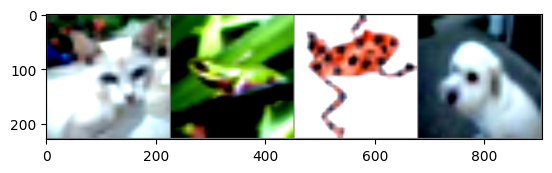

cat   frog  frog  dog  


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Load Pretrained Model

Here we'll be using [AlexNet](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) architecture pretrained with [ImageNet](https://www.image-net.org/update-mar-11-2021.php)

In [7]:
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
alexnet = alexnet.to(device)

Optionally freeze convolutional layers (feature extractor)

In [8]:
for param in alexnet.features.parameters():
    param.requires_grad = False

Replace the last classifier layer to output 10 classes (CIFAR-10)

In [9]:
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 10)
alexnet.classifier[6].requires_grad = True
alexnet = alexnet.to(device)

Specify the loss function and optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, alexnet.parameters()), lr=1e-3)

# Training the network


In [ ]:
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0

    loop = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update tqdm description
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(trainloader)
    print(f"Epoch {epoch+1} completed. Avg Loss = {epoch_loss:.4f}\n")

## Saving the model

In [ ]:
PATH = './cifar_transfer.pth'
torch.save(alexnet.state_dict(), PATH)

## Test the network on the test data

We'll see train and test losses, together with its accuracies per epoch. Note that the training data have more minor losses and reach an accuracy of almost 100%. On the other hand, the test data reach almost a plateau of > 95% accuracy, and we could think of using more than two epochs because this is where the training data crosses the accuracy of the testing data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7938564].


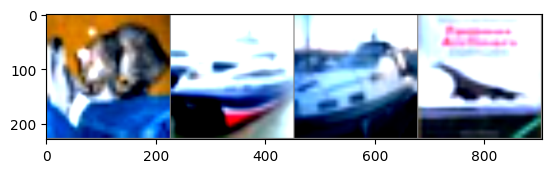

GroundTruth:  cat   ship  ship  plane


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [13]:
PATH = './cifar_transfer.pth'
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
alexnet = alexnet.to(device)

state_dict = torch.load(PATH, map_location=device)
alexnet.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for AlexNet:
	size mismatch for classifier.6.weight: copying a param with shape torch.Size([10, 4096]) from checkpoint, the shape in current model is torch.Size([1000, 4096]).
	size mismatch for classifier.6.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([1000]).

Let us see what the neural network thinks these examples above are:

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

Let us look at how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Let's breakdown the classes accuracy

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
# Calculate and show the confusion matrix heatmap
confusion_matrix = torch.zeros(len(classes), len(classes))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # images = images.to(device)  # Uncomment if running on GPU
        # labels = labels.to(device)  # Uncomment if running on GPU
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add count annotations
thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, int(confusion_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()
